In [1]:
from Functions import*



In [2]:
import glob
from statistics import *

In [3]:
#function that create a list from lines in a txt file
#allows to know which image is in which set
def create_list_from_txt(filename):
    FILE = filename
 
    with open(FILE, 'r') as f:
        lines = [line.strip('\n') for line in f.readlines()]
 
    list_img = [line for line in lines]
    
    return list_img
   

In [4]:
#function that create the lists of image but already split in test, train and val sets
#we are going to use this function to load data in the right sets
#two times  for COVID and NonCOVID

#set_type is either train,test or val
def create_set_list_splits(covid): 
    folder_path='/tf/Project/Data_split'
    if covid==True:
        set_dir=os.path.join(folder_path+'/COVID')
    else: 
        set_dir=os.path.join(folder_path+'/NonCOVID')
    
    
    list_files=glob.glob(set_dir+'/*.txt')
    list_files.sort()
    #to ensure the order of sets as test , train and val (alphabetic order)
    
    
    test_list=create_list_from_txt(list_files[0])
    train_list=create_list_from_txt(list_files[1])
    val_list=create_list_from_txt(list_files[2])
    
    return test_list, train_list, val_list

In [5]:
#add the name of image to the name of folder
#create the full name of the image to be loaded
def list_dir(set_list,set_dir):
    new_data=[]
    for x in set_list:
        new = os.path.join(set_dir,x)
        new_data.append(new)
    return new_data

In [6]:
#tbl stands for to be loaded
def create_list_to_load(test_list,train_list, val_list, covid):
    img_path='/tf/Project'
    
    if covid==True:
        set_dir=os.path.join(img_path+'/CT_COVID')
    else: 
        set_dir=os.path.join(img_path+'/CT_NonCOVID')
    
    test_list_tbl=list_dir(test_list,set_dir)
    train_list_tbl=list_dir(train_list,set_dir)
    val_list_tbl=list_dir(val_list,set_dir)
    
    return test_list_tbl, train_list_tbl, val_list_tbl

In [7]:
def load_data(data_list,img_w,img_h,img_ch):
    tab = np.zeros((len(data_list),img_w,img_h,img_ch),dtype='float32')
    tab2 = np.zeros((len(data_list),img_w,img_h,img_ch),dtype='float32')
    tab_mean = []
    tab_std = []
    for i in range(len(data_list)):
        Img = cv2.imread(data_list[i],0)
        Img = cv2.resize(Img,(img_w, img_h))
        Img = Img.reshape(img_w,img_h)/255
        tab[i,:,:,0]=Img
        tab_mean.append(Img.mean())
        tab_std.append(Img.std())
    set_mean = mean(tab_mean)
    set_std = stdev(tab_std)
    for i in range(len(data_list)):
        tab2[i,:,:,0]=(tab[i,:,:,0]-set_mean)/set_std          
    return tab2

In [8]:
def create_list_labels(set_list,covid): 
    list_labels=[]
    for i in range(len(set_list)):
        if covid==True:
            list_labels.append(1)
        else:
            list_labels.append(0)
    return list_labels

In [9]:
def concatenate_lists_and_labels(list1,labels1,list2,labels2):
    return list1+list2, labels1+labels2

In [10]:
def shuffle_lists(list_img, list_labels):
    index_position = list(zip(list_img, list_labels))
    random.shuffle(index_position)
    list_img[:],list_labels[:] = zip(*index_position)
    return list_img,list_labels

In [11]:
def precision(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_pred_f) + K.epsilon())

def recall(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.epsilon())

In [12]:
#labels is an array
def augmentation(image_set,labels,dictionary_augmentation,batch_size):
    
    image_datagen = ImageDataGenerator(**dictionary_augmentation)
    image_generator = image_datagen.flow(
    image_set,
    y=labels,
    batch_size=batch_size,
    shuffle=False,
    seed=1)
    
    return image_generator

In [13]:
test_list_covid, train_list_covid, val_list_covid=create_set_list_splits(covid=True)
test_list_Noncovid, train_list_Noncovid, val_list_Noncovid=create_set_list_splits(covid=False)

In [14]:
test_list_tbl_covid, train_list_tbl_covid,val_list_tbl_covid=create_list_to_load(test_list_covid,train_list_covid, val_list_covid, covid=True)

test_list_tbl_Noncovid, train_list_tbl_Noncovid,val_list_tbl_Noncovid=create_list_to_load(test_list_Noncovid,train_list_Noncovid, val_list_Noncovid, covid=False)

In [15]:
test_covid_labels=create_list_labels(test_list_covid,covid=True)
train_covid_labels=create_list_labels(train_list_covid,covid=True)
val_covid_labels=create_list_labels(val_list_covid,covid=True)

test_Noncovid_labels=create_list_labels(test_list_Noncovid,covid=False)
train_Noncovid_labels=create_list_labels(train_list_Noncovid,covid=False)
val_Noncovid_labels=create_list_labels(val_list_Noncovid,covid=False)

In [16]:
test_list_tbl,test_labels=concatenate_lists_and_labels(test_list_tbl_covid,test_covid_labels,test_list_tbl_Noncovid,test_Noncovid_labels)
train_list_tbl,train_labels=concatenate_lists_and_labels(train_list_tbl_covid,train_covid_labels,train_list_tbl_Noncovid,train_Noncovid_labels)
val_list_tbl,val_labels=concatenate_lists_and_labels(val_list_tbl_covid,val_covid_labels,val_list_tbl_Noncovid,val_Noncovid_labels)

In [17]:
test_list_tbl,test_labels=shuffle_lists(test_list_tbl, test_labels)
train_list_tbl,train_labels=shuffle_lists(train_list_tbl, train_labels)
val_list_tbl,val_labels=shuffle_lists(val_list_tbl, val_labels)



In [18]:
#the article precises the size of the images as (480,480)

img_w,img_h,img_ch=480,480,1
test_set=load_data(test_list_tbl,img_w,img_h,img_ch)
train_set=load_data(train_list_tbl,img_w,img_h,img_ch)
val_set=load_data(val_list_tbl,img_w,img_h,img_ch)


In [19]:
test_labels=np.array(test_labels)
train_labels=np.array(train_labels)
val_labels=np.array(val_labels)

In [20]:
from skimage.io import imshow

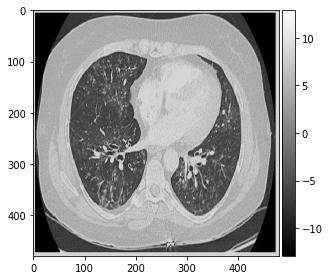

In [21]:
imshow(np.squeeze(train_set[1]),cmap='gray')

In [22]:
from tensorflow.keras.layers import Conv2D,AveragePooling2D,add, GlobalAveragePooling2D, ReLU

In [23]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [24]:
INPUT_SHAPE=480,480,1
N_CLASSES=1

K.clear_session()
my_model=Alex_model(1,480,480)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 480, 8)       80        
_________________________________________________________________
activation (Activation)      (None, 480, 480, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 240, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 16)      1168      
_________________________________________________________________
activation_1 (Activation)    (None, 240, 240, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 32)      4

In [25]:
learning_rate=0.00001
optimizer=Adam(learning_rate)
batch_size=16
loss_function = 'binary_crossentropy'
metrics=['binary_accuracy',precision,recall]
n_epochs=200

In [26]:
#data augmentation
dictionary_augmentation = dict(
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,       
                     horizontal_flip=True,
                     brightness_range=[0,2])


In [27]:
 STEP_SIZE_TRAIN=len(train_set)//batch_size
    

In [28]:
train_generator=augmentation(train_set,train_labels,dictionary_augmentation,batch_size=batch_size)


In [29]:
my_model.compile(loss=loss_function,optimizer = optimizer,metrics=['binary_accuracy'])

In [30]:
model_hist=my_model.fit_generator(generator=train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=(test_set,test_labels)
                        ,epochs=n_epochs,verbose=1)

Epoch 1/200
26/26 [==============================] - 4s 165ms/step - loss: 2.6691 - binary_accuracy: 0.5208 - val_loss: 0.6956 - val_binary_accuracy: 0.4975
Epoch 2/200
26/26 [==============================] - 4s 158ms/step - loss: 1.8676 - binary_accuracy: 0.5330 - val_loss: 0.6928 - val_binary_accuracy: 0.4975
Epoch 3/200
26/26 [==============================] - 4s 153ms/step - loss: 1.3124 - binary_accuracy: 0.5433 - val_loss: 0.6945 - val_binary_accuracy: 0.4778
Epoch 4/200
26/26 [==============================] - 4s 156ms/step - loss: 1.0996 - binary_accuracy: 0.5770 - val_loss: 0.6918 - val_binary_accuracy: 0.5222
Epoch 5/200
26/26 [==============================] - 4s 148ms/step - loss: 0.9379 - binary_accuracy: 0.5448 - val_loss: 0.6916 - val_binary_accuracy: 0.5222
Epoch 6/200
26/26 [==============================] - 4s 153ms/step - loss: 0.8887 - binary_accuracy: 0.5672 - val_loss: 0.6902 - val_binary_accuracy: 0.5369
Epoch 7/200
26/26 [==============================] - 4s 15

Epoch 53/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6502 - binary_accuracy: 0.6577 - val_loss: 0.6773 - val_binary_accuracy: 0.4975
Epoch 54/200
26/26 [==============================] - 4s 150ms/step - loss: 0.6480 - binary_accuracy: 0.6039 - val_loss: 0.6768 - val_binary_accuracy: 0.4975
Epoch 55/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6524 - binary_accuracy: 0.6381 - val_loss: 0.6793 - val_binary_accuracy: 0.5172
Epoch 56/200
26/26 [==============================] - 4s 152ms/step - loss: 0.6552 - binary_accuracy: 0.6797 - val_loss: 0.6766 - val_binary_accuracy: 0.4877
Epoch 57/200
26/26 [==============================] - 4s 150ms/step - loss: 0.6568 - binary_accuracy: 0.6308 - val_loss: 0.6752 - val_binary_accuracy: 0.4926
Epoch 58/200
26/26 [==============================] - 4s 149ms/step - loss: 0.6422 - binary_accuracy: 0.5892 - val_loss: 0.6778 - val_binary_accuracy: 0.5074
Epoch 59/200
26/26 [==============================] 

Epoch 105/200
26/26 [==============================] - 4s 152ms/step - loss: 0.6349 - binary_accuracy: 0.6235 - val_loss: 1.1281 - val_binary_accuracy: 0.5123
Epoch 106/200
26/26 [==============================] - 4s 153ms/step - loss: 0.6362 - binary_accuracy: 0.6210 - val_loss: 1.1229 - val_binary_accuracy: 0.5172
Epoch 107/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6255 - binary_accuracy: 0.6601 - val_loss: 1.1635 - val_binary_accuracy: 0.5123
Epoch 108/200
26/26 [==============================] - 4s 150ms/step - loss: 0.6155 - binary_accuracy: 0.6724 - val_loss: 1.2375 - val_binary_accuracy: 0.5222
Epoch 109/200
26/26 [==============================] - 4s 152ms/step - loss: 0.6726 - binary_accuracy: 0.6430 - val_loss: 1.1750 - val_binary_accuracy: 0.5222
Epoch 110/200
26/26 [==============================] - 4s 157ms/step - loss: 0.6377 - binary_accuracy: 0.6944 - val_loss: 1.1967 - val_binary_accuracy: 0.5074
Epoch 111/200
26/26 [=========================

26/26 [==============================] - 4s 152ms/step - loss: 0.5878 - binary_accuracy: 0.6626 - val_loss: 2.2892 - val_binary_accuracy: 0.5172
Epoch 157/200
26/26 [==============================] - 4s 152ms/step - loss: 0.5927 - binary_accuracy: 0.6553 - val_loss: 2.3641 - val_binary_accuracy: 0.5172
Epoch 158/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6057 - binary_accuracy: 0.6797 - val_loss: 2.5227 - val_binary_accuracy: 0.5172
Epoch 159/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6154 - binary_accuracy: 0.6675 - val_loss: 2.5331 - val_binary_accuracy: 0.5172
Epoch 160/200
26/26 [==============================] - 4s 152ms/step - loss: 0.6314 - binary_accuracy: 0.6137 - val_loss: 2.4781 - val_binary_accuracy: 0.5222
Epoch 161/200
26/26 [==============================] - 4s 151ms/step - loss: 0.6016 - binary_accuracy: 0.6692 - val_loss: 2.3021 - val_binary_accuracy: 0.5222
Epoch 162/200
26/26 [==============================] - 4s 15

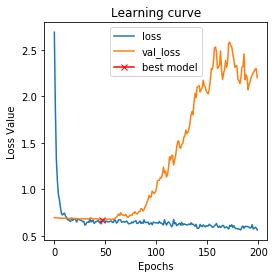

In [31]:
loss_curves_plot(model_hist)

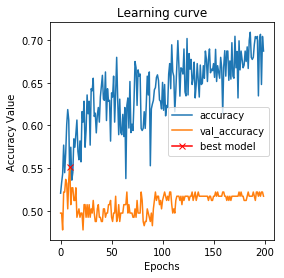

In [32]:
accuracy_curves_plot(model_hist,'binary_accuracy')

In [ ]:
Sample = train_list_tbl[1]
Img = imread(Sample)
Img = Img[:,:,0]
Img = Img/255
Img = resize(Img, (img_h, img_w), anti_aliasing = True).astype('float32')
Img = np.expand_dims(Img, axis = 2)
Img = np.expand_dims(Img, axis = 0)
preds = my_model.predict(Img)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = my_model.output[:, class_idx]
last_conv_layer = my_model.get_layer("conv2d_4")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([my_model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([Img])
for i in range(16):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
img = cv2.imread(Sample)
img = cv2.resize(img, (480, 480), interpolation = cv2.INTER_AREA)
#img = img/255
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(superimposed_img)